# Libraries

In [1]:
import pandas as pd
import numpy as np
import time
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression

# All Batteries

In [2]:
b5 = pd.read_excel('C:/Users/ibrah/Desktop/Masters/Final/all notebooks/AV_b05.xlsx')
b6 = pd.read_excel('C:/Users/ibrah/Desktop/Masters/Final/all notebooks/AV_b06.xlsx')
b7 = pd.read_excel('C:/Users/ibrah/Desktop/Masters/Final/all notebooks/AV_b07.xlsx')
b18 = pd.read_excel('C:/Users/ibrah/Desktop/Masters/Final/all notebooks/AV_b018.xlsx')

## EDA

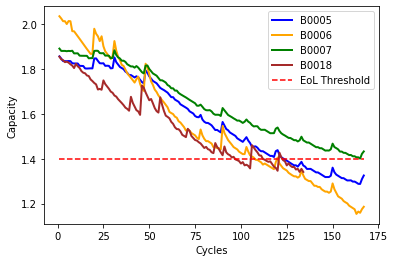

For battery 5, the capacity reaches the threshold of 1.4 at cycle: 124
For battery 6, the capacity reaches the threshold of 1.4 at cycle: 108
For battery 7, the capacity reaches the threshold of 1.41 at cycle: 163
For battery 18, the capacity reaches the threshold of 1.4 at cycle: 97


In [3]:
# Indicate the threshold index where capacity first reaches 1.4 and 1.41 
threshold_index1 = b5[b5['Capacity'] <= 1.4].index.min()
threshold_index2= b6[b6['Capacity'] <= 1.4].index.min()
threshold_index3 = b7[b7['Capacity'] <= 1.41].index.min()
threshold_index4 = b18[b18['Capacity'] <= 1.4].index.min()

# Indicate the cycle number where capacity first reaches the threshold index
cycle_at_threshold1 = b5.loc[threshold_index1, 'new_cycle_type']
cycle_at_threshold2= b6.loc[threshold_index2, 'new_cycle_type']
cycle_at_threshold3 = b7.loc[threshold_index3, 'new_cycle_type']
cycle_at_threshold4 = b18.loc[threshold_index4, 'new_cycle_type']

# Plot the Capacity versus cycle
plt.plot(b5['new_cycle_type'], b5['Capacity'], color='blue', linewidth = 2, label='B0005')
plt.plot(b6['new_cycle_type'], b6['Capacity'], color='orange', linewidth = 2, label='B0006')
plt.plot(b7['new_cycle_type'], b7['Capacity'], color='green', linewidth = 2, label='B0007')
plt.plot(b18['new_cycle_type'], b18['Capacity'], color='brown', linewidth = 2, label='B0018')
# Plot the threshold line
plt.plot([b5['new_cycle_type'].min(), b5['new_cycle_type'].max()], [1.4, 1.4], linestyle='--', color='red', label='EoL Threshold')

# Set labels
plt.ylabel('Capacity')
plt.xlabel('Cycles')

# Insert legend and illustrate the plot
plt.legend()
plt.show()

# Return the cycle where capacity reaches the threshold index for each battery
print("For battery 5, the capacity reaches the threshold of 1.4 at cycle:", cycle_at_threshold1)
print("For battery 6, the capacity reaches the threshold of 1.4 at cycle:", cycle_at_threshold2)
print("For battery 7, the capacity reaches the threshold of 1.41 at cycle:", cycle_at_threshold3)
print("For battery 18, the capacity reaches the threshold of 1.4 at cycle:", cycle_at_threshold4)

In [ ]:
# adjust the dataframes to only include data up to the threshold index
b5 = b5.head(124)
b5['RUL'] = list(range(124, 0, -1))
b6 = b6.head(108)
b6['RUL'] = list(range(108, 0, -1))
b7 = b7.head(163)
b7['RUL'] = list(range(163, 0, -1))
b18 = b18.head(97)
b18['RUL'] = list(range(97, 0, -1))

In [5]:
# Train dataset (B0005, B0006 and B0007)
ab = pd.concat([b5, b6, b7], ignore_index=True)

In [6]:
ab.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
new_cycle_type,395.0,68.36,41.55,1.00,33.50,66.00,99.00,163.00
Voltage_measured_C,395.0,4.21,0.00,4.20,4.21,4.21,4.21,4.22
Time_Voltage_Measured_C,395.0,5358.22,2523.91,1421.48,3193.41,3764.20,7967.27,9538.16
Current_measured_time_C,395.0,2652.41,554.74,717.52,2207.40,2652.78,3184.50,3608.81
Current_measured_C,395.0,1.49,0.02,1.42,1.49,1.49,1.51,1.52
Temperature_measured_C,395.0,29.21,0.59,27.26,28.90,29.19,29.54,31.19
Time_temperature_measured_C,395.0,2926.82,483.38,1006.09,2506.96,2913.17,3382.44,3894.33
Current_C,395.0,1.45,0.11,0.85,1.44,1.48,1.50,1.51
Time_current_C,395.0,2690.87,582.12,717.52,2229.05,2667.05,3211.26,4140.62
Voltage_C,395.0,4.94,0.01,4.92,4.94,4.95,4.95,4.96


In [7]:
# Categorical variables will be excluded as they were added to each dataset for the purpose of making it easy to identify which data corresponds to which battery as well as what cycles are charge and what cycles are discharge.
ab = ab.drop(columns=['type_C', 'type_D',"Battery_id", 'Capacity'])

In [8]:
# Executing this to check in particular the Dtype, so we making sure that all the numeric variables have the correct data type
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   new_cycle_type               395 non-null    int64  
 1   Voltage_measured_C           395 non-null    float64
 2   Time_Voltage_Measured_C      395 non-null    float64
 3   Current_measured_time_C      395 non-null    float64
 4   Current_measured_C           395 non-null    float64
 5   Temperature_measured_C       395 non-null    float64
 6   Time_temperature_measured_C  395 non-null    float64
 7   Current_C                    395 non-null    float64
 8   Time_current_C               395 non-null    float64
 9   Voltage_C                    395 non-null    float64
 10  Time_Voltage_C               395 non-null    float64
 11  Charge Total Time            395 non-null    float64
 12  Voltage_measured_D           395 non-null    float64
 13  Time_voltage_measure

In [9]:
b18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Battery_id                   97 non-null     object 
 1   new_cycle_type               97 non-null     int64  
 2   type_C                       97 non-null     object 
 3   Voltage_measured_C           97 non-null     float64
 4   Time_Voltage_Measured_C      97 non-null     float64
 5   Current_measured_time_C      97 non-null     float64
 6   Current_measured_C           97 non-null     float64
 7   Temperature_measured_C       97 non-null     float64
 8   Time_temperature_measured_C  97 non-null     float64
 9   Current_C                    97 non-null     float64
 10  Time_current_C               97 non-null     float64
 11  Voltage_C                    97 non-null     float64
 12  Time_Voltage_C               97 non-null     float64
 13  Charge Total Time     

## Correlation Matrix

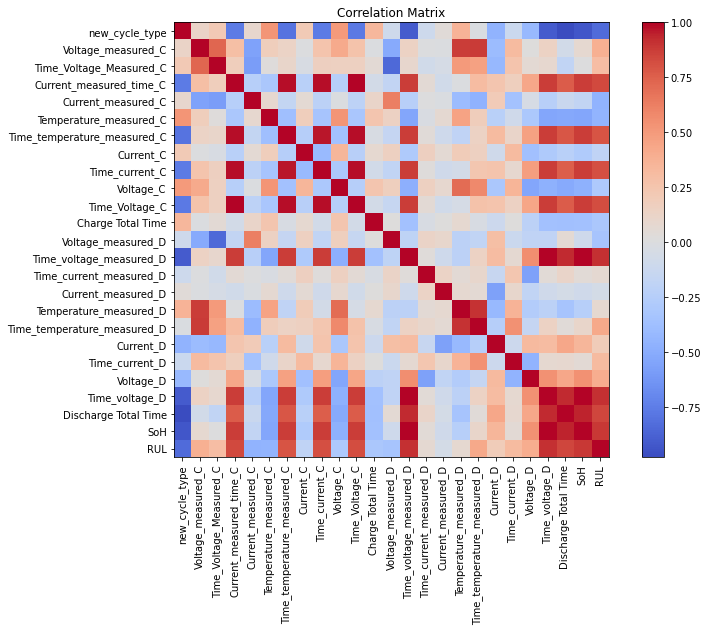

In [10]:
# correlation matrix
corr = ab.corr()
plt.figure(figsize=(12, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

# Feature Selection

In [11]:
# Drop target variable from feature set
X = ab.drop(columns=['RUL'], axis =1)
y = ab['RUL']

In [12]:
# Select top 5 features using f_regression scoring function
selector = SelectKBest(score_func=f_regression, k=5)

# Fit selector
selector.fit(X, y)

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Get names of selected features
selected_feature_names = ab.columns[selected_indices]

# Print names of selected features
print("Names of selected features:", selected_feature_names)

Names of selected features: Index(['new_cycle_type', 'Time_voltage_measured_D', 'Time_voltage_D',
       'Discharge Total Time', 'SoH'],
      dtype='object')


# First Iteration

In [13]:
# Test and Train data
X_train = ab[['new_cycle_type', 'Time_voltage_measured_D', 'Time_voltage_D', 'Discharge Total Time', 'SoH']]
y_train = ab['RUL']

X_test = b18[['new_cycle_type', 'Time_voltage_measured_D', 'Time_voltage_D', 'Discharge Total Time', 'SoH']]
y_test = b18['RUL']

## Baseline Model

In [ ]:
# Linear Regression model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse: .2f}")
print(f"Mean Absolute Error: {mae: .2f}")
print(f"Mean Absolute Percentage Error: {mape: .2%}")

Root Mean Squared Error:  29.25
Mean Absolute Error:  28.64
Mean Absolute Percentage Error:  189.13%


In [15]:
# Dataframe (pdf) to compare actual vs predicted values
pdf = pd.DataFrame({'Cycle': b18['new_cycle_type'],'Actual': y_test, 'Predicted_LR': y_pred})
pdf

,Cycle,Actual,Predicted_LR
0,1,97,123.042614
1,2,96,122.327072
2,3,95,122.599748
3,4,94,121.239895
4,5,93,118.801202
...,...,...,...
92,93,5,44.725196
93,94,4,44.079510
94,95,3,43.194201
95,96,2,43.467084


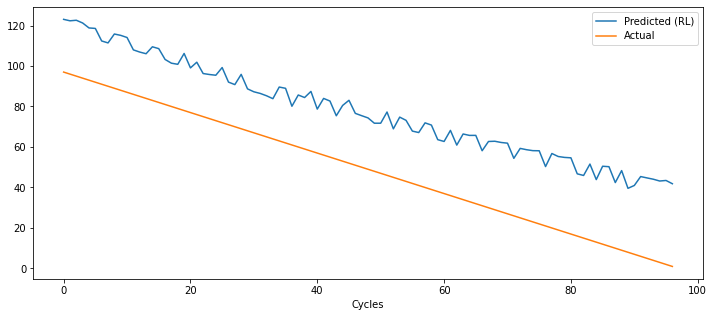

In [16]:
# Visualize predicted RUL vs Actual RUL
ypred = pd.Series(y_pred)
ytest = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred, label = "Predicted (RL)")
ax.plot(ytest, label = "Actual")
ax.set_xlabel("Cycles")


plt.legend()
plt.show()

## RF

In [17]:
# Random Forest Regressor object
model_rf = RandomForestRegressor(n_estimators=100, 
                                     max_depth= None,
                                     max_features= "sqrt",
                                     min_samples_split= 2)

# Train the model
model_rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"Root Mean Squared Error: {rmse_rf: .2f}")
print(f"Mean Absolute Error: {mae_rf: .2f}")
print(f"Mean Absolute Percentage Error: {mape_rf: .2%}")

Root Mean Squared Error:  9.71
Mean Absolute Error:  7.65
Mean Absolute Percentage Error:  24.69%


In [21]:
# Dataframe (pdf) to compare actual vs predicted values
pdf['Predicted_RF'] = y_pred_rf
pdf

,Cycle,Actual,Predicted_LR,Predicted_XGB,Predicted_RF
0,1,97,123.042614,115.557152,110.77
1,2,96,122.327072,116.591278,113.34
2,3,95,122.599748,115.506203,112.60
3,4,94,121.239895,119.670898,114.03
4,5,93,118.801202,121.542900,114.11
...,...,...,...,...,...
92,93,5,44.725196,6.173754,8.11
93,94,4,44.079510,5.136897,6.61
94,95,3,43.194201,1.794338,4.52
95,96,2,43.467084,3.916913,5.01


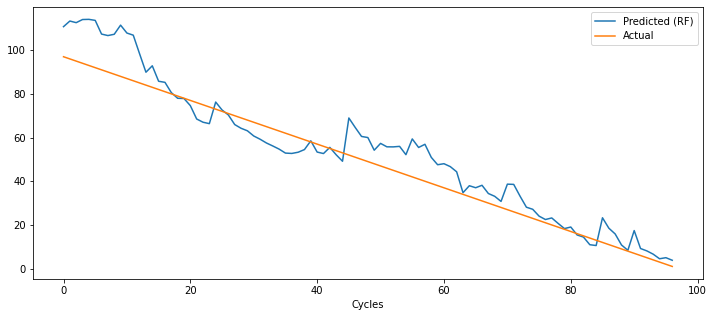

In [18]:
# Visualize predicted RUL vs Actual RUL
ypred = pd.Series(y_pred_rf)
ytest = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred, label = "Predicted (RF)")
ax.plot(ytest, label = "Actual")
ax.set_xlabel("Cycles")


plt.legend()
plt.show()

## XGBoost

In [19]:
# Define the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', 
                              n_estimators = 100, 
                              learning_rate = 0.3,
                              max_depth = 6, 
                              subsample = 1,
                              booster = 'gbtree')
# Train the model
model_xgb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_XGB = model_xgb.predict(X_test)

# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_XGB))
mae_xgb = mean_absolute_error(y_test, y_pred_XGB)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_XGB)
print(f"Mean Squared Error: {rmse_xgb:.2f}")
print(f"Mean Absolute Error: {mae_xgb:.2f}")
print(f"Mean Absolute Percentage Error: {mape_xgb:.2%}")

Mean Squared Error: 12.13
Mean Absolute Error: 10.09
Mean Absolute Percentage Error: 25.59%


In [20]:
# Dataframe (pdf) to compare actual vs predicted values
pdf['Predicted_XGB'] = y_pred_XGB
pdf

,Cycle,Actual,Predicted_LR,Predicted_XGB
0,1,97,123.042614,115.557152
1,2,96,122.327072,116.591278
2,3,95,122.599748,115.506203
3,4,94,121.239895,119.670898
4,5,93,118.801202,121.542900
...,...,...,...,...
92,93,5,44.725196,6.173754
93,94,4,44.079510,5.136897
94,95,3,43.194201,1.794338
95,96,2,43.467084,3.916913


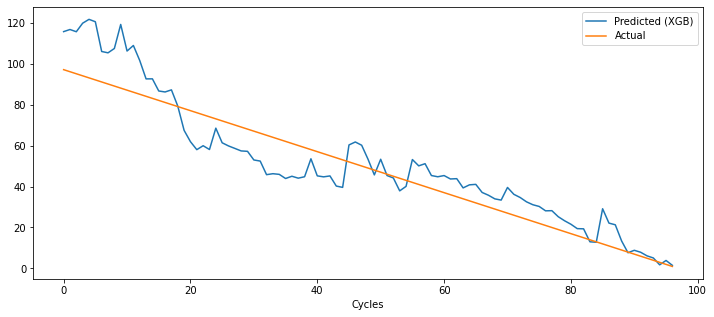

In [22]:
# Visualize predicted RUL vs Actual RUL
ypred = pd.Series(y_pred_XGB)
ytest = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred, label = "Predicted (XGB)")
ax.plot(ytest, label = "Actual")
ax.set_xlabel("Cycles")


plt.legend()
plt.show()

# Second Iteration

## Fine-tuning Hyperparameters of Random Forest and XGBoost using GridsearchCV

### Fine - tuning Hyperparameters Random Forest

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False) # Minimize RMSE

#### GridSearchCV - RF

In [ ]:
# Start the timer
start_time = time.perf_counter()

# Random Forest Model 
rf_model = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt','log2'],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=rmse_scorer,   # minimize RMSE (Negative values internally)
    cv=cv,
    n_jobs=-1,
    refit=True,            # refit no training data
    verbose=0
)

grid_search_rf.fit(X_train, y_train)

best_rf_grid = grid_search_rf.best_estimator_
best_params = grid_search_rf.best_params_
best_cv_rmse = -grid_search_rf.best_score_   # invert to positive RMSE

print("RF (Grid) best params:", best_params)
print(f"RF (Grid) best RMSE (CV): {best_cv_rmse:.4f}")

# Stop the timer
end_time = time.perf_counter()
total_time = end_time - start_time
rounded_time_grid_rf = round(total_time, 2)
print(f"Execution time: {rounded_time_grid_rf} seconds")

# Save to compare resdults with Optuna
metrics_grid_rf = {
    'rmse_cv': float(best_cv_rmse),
    'time_seconds': float(rounded_time_grid_rf),
    'best_params': best_params
}


RF (Grid) best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
RF (Grid) best RMSE (CV): 9.3461
Execution time: 103.04 seconds


#### Optuna - RF

In [ ]:
# Hyperparameter tuning for Random Forest using Optuna
# Start timer
start_time = time.perf_counter()
# Define the objective function for Optuna
def objective_rf(trial):
    # Define the hyperparameter search space for RandomForestRegressor
    params_rf = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }
    
    # Create a Random Forest Regressor with the current hyperparameters
    rf_model = RandomForestRegressor(**params_rf)
    
      # RMSE via CV only on training data
    scores = cross_val_score(
        rf_model,
        X_train, y_train,
        cv=cv,
        scoring=rmse_scorer,
        n_jobs=-1
    )
    # invert to positive RMSE
    rmse_cv = -np.mean(scores)
    return rmse_cv
    

# Create an Optuna study and optimize the objective function
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=50)

# Best hyperparameters e melhor RMSE-CV
best_params_rf = study_rf.best_params
best_rmse_cv_rf = study_rf.best_value

print("Best hyperparameters for Random Forest (Optuna):", best_params_rf)
print(f"Best CV RMSE (Optuna): {best_rmse_cv_rf:.4f}")

# Train the best model with the optimized hyperparameters only on training data
rf_model_optimized = RandomForestRegressor(**{**best_params_rf, 'random_state': 42, 'n_jobs': -1})
rf_model_optimized.fit(X_train, y_train)

# End time measurement
end_time = time.perf_counter()
total_time = end_time - start_time
rounded_time_opt_rf = round(total_time, 2)
print(f"Execution time: {rounded_time_opt_rf} seconds")

# save to compare results with GridSearchCV
metrics_optuna_rf = {
    'rmse_cv': float(best_rmse_cv_rf),
    'time_seconds': float(rounded_time_opt_rf),
    'best_params': best_params_rf
}

[I 2025-10-30 00:15:32,496] A new study created in memory with name: no-name-6a0f1a71-2dbc-4b40-9cda-ea2e5d57388c
[I 2025-10-30 00:15:35,420] Trial 0 finished with value: 17.090906794501898 and parameters: {'n_estimators': 809, 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 2}. Best is trial 0 with value: 17.090906794501898.
[I 2025-10-30 00:15:37,819] Trial 1 finished with value: 10.44362902190791 and parameters: {'n_estimators': 481, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 10}. Best is trial 1 with value: 10.44362902190791.
[I 2025-10-30 00:15:41,918] Trial 2 finished with value: 9.841357112010536 and parameters: {'n_estimators': 929, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 7}. Best is trial 2 with value: 9.841357112010536.
[I 2025-10-30 00:15:46,142] Trial 3 finished with value: 10.07991748746014 and parameters: {'n_estimators': 782, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 5}. Best is trial 2 with value: 9

Best hyperparameters for Random Forest (Optuna): {'n_estimators': 507, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2}
Best CV RMSE (Optuna): 9.2889
Execution time: 113.22 seconds


In [26]:
# Compare the results of both hyperparameter tuning methods mse, mae, mape and time taken and indicate which one is better
results_rf = pd.DataFrame({
    "Method": ["GridSearchCV", "Optuna"],
    "RMSE": [best_cv_rmse, best_rmse_cv_rf],
    "Time (s)": [rounded_time_grid_rf, rounded_time_opt_rf]
})

print(results_rf)

         Method      RMSE  Time (s)
0  GridSearchCV  9.346086    103.04
1        Optuna  9.288948    113.22


### Fine - tuning Hyperparameters - XGBoost

#### GridSearchCV - XGBoost

In [ ]:
# Hyperparameter tuning for XGBoost using GridSearchCV
# Define the parameter grid for hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [None, 1, 2, 3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1],
    'booster': ['gbtree']
}

# Start the timer
start_time = time.perf_counter()

# Create an XGBoost Regressor object
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')


# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model,
                                param_grid=param_grid_xgb,
                                scoring=rmse_scorer,   # minimize RMSE (Negative values internally)
                                cv=cv,
                                verbose=2,
                                refit=True,            # refit in training dataset 
                                n_jobs=-1)

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters
best_params_xgb = grid_search_xgb.best_params_
best_params = grid_search_xgb.best_params_
best_cv_rmse = -grid_search_xgb.best_score_   # invert to positive RMSE

print("XGB (Grid) best params:", best_params)
print(f"XGB (Grid) best RMSE (CV): {best_cv_rmse:.4f}")

# Stop the timer
end_time = time.perf_counter()
total_time = end_time - start_time
rounded_time_grid_xgb = round(total_time, 2)
print(f"Execution time: {rounded_time_grid_xgb} seconds")

# save to compare results with Optuna
metrics_grid_rf = {
    'rmse_cv': float(best_cv_rmse),
    'time_seconds': float(rounded_time_grid_xgb),
    'best_params': best_params
}

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
XGB (Grid) best params: {'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.6}
XGB (Grid) best RMSE (CV): 7.5358
Execution time: 105.26 seconds


#### Optuna - XGBoost

In [ ]:
# Hyperparameter tuning for XGBoost using Optuna
# Start timer
start_time = time.perf_counter()

# Define the objective function for Optuna
def objective_xgb(trial):

    # Define the hyperparameter search space
    params_xgb = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0, 1.0),
        'booster': 'gbtree'
    }
    
    # Create an XGBoost Regressor with the current hyperparameters
    xgb_model = xgb.XGBRegressor(**params_xgb)
    
    # # RMSE via CV only on training data
    scores = cross_val_score(
        xgb_model,
        X_train, y_train,
        cv=cv,
        scoring=rmse_scorer,
        n_jobs=-1
    )
    # convert to positive RMSE
    rmse_cv = -np.mean(scores)
    return rmse_cv


# Create an Optuna study and optimize the objective function
study_xgb = optuna.create_study(direction='minimize', study_name="XGBoost Hyperparameter Tuning")
study_xgb.optimize(objective_xgb, n_trials=50)

# Get the best hyperparameters
best_params_xgb = study_xgb.best_params
best_rmse_cv_xgb = study_xgb.best_value

print("Best hyperparameters for Random Forest (Optuna):", best_params_xgb)
print(f"Best CV RMSE (Optuna): {best_rmse_cv_xgb:.4f}")

# Train the best model with the optimized hyperparameters
xgb_model_optimized = xgb.XGBRegressor(**{**best_params_xgb, 'random_state': 42, 'n_jobs': -1})
xgb_model_optimized.fit(X_train, y_train)

# End timer
end_time = time.perf_counter()
total_time = end_time - start_time
rounded_time_opt_xgb = round(total_time, 2)
print(f"Total time for hyperparameter tuning: {total_time:.2f} seconds")
print(f"Execution time: {rounded_time_opt_xgb} seconds")

# save to compare results with GridSearchCV
metrics_optuna_xgb = {
    'rmse_cv': float(best_rmse_cv_rf),
    'time_seconds': float(rounded_time_opt_xgb),
    'best_params': best_params_xgb
}

[I 2025-10-30 00:21:14,758] A new study created in memory with name: XGBoost Hyperparameter Tuning
[I 2025-10-30 00:21:15,447] Trial 0 finished with value: 10.457392278452048 and parameters: {'n_estimators': 834, 'learning_rate': 0.7041821421022434, 'max_depth': 10, 'subsample': 0.526237560833491}. Best is trial 0 with value: 10.457392278452048.
[I 2025-10-30 00:21:15,781] Trial 1 finished with value: 8.015153474391758 and parameters: {'n_estimators': 302, 'learning_rate': 0.256332683826222, 'max_depth': 4, 'subsample': 0.6564803380515201}. Best is trial 1 with value: 8.015153474391758.
[I 2025-10-30 00:21:16,159] Trial 2 finished with value: 7.968651134789191 and parameters: {'n_estimators': 243, 'learning_rate': 0.41096810918855864, 'max_depth': 8, 'subsample': 0.3479491851805593}. Best is trial 2 with value: 7.968651134789191.
[I 2025-10-30 00:21:16,352] Trial 3 finished with value: 21.570020848462224 and parameters: {'n_estimators': 186, 'learning_rate': 0.9796347988251191, 'max_de

Best hyperparameters for Random Forest (Optuna): {'n_estimators': 533, 'learning_rate': 0.17108066551696888, 'max_depth': 4, 'subsample': 0.19673768590159135}
Best CV RMSE (Optuna): 7.4447
Execution time: 113.22 seconds


In [29]:
# Compare the results of both hyperparameter tuning methods mse, mae, mape and time taken and indicate which one is better
results_xgb = pd.DataFrame({
    "Method": ["GridSearchCV", "Optuna"],
    "RMSE": [best_cv_rmse, best_rmse_cv_xgb],
    "Time (s)": [rounded_time_grid_xgb, rounded_time_opt_xgb]
})

print(results_xgb)

         Method      RMSE  Time (s)
0  GridSearchCV  7.535811    105.26
1        Optuna  7.444678     26.99


## Training Optimized RF and XGB with tuned Hyperparameters

### RF

In [35]:
# train Random Forest with the best hyperparameters found by Optuna
rf_model_tuned = RandomForestRegressor(**best_params_rf)
rf_model_tuned.fit(X_train, y_train)

# Make final predictions with the optimized models
y_pred_tuned_rf = rf_model_tuned.predict(X_test)

# Evaluate the final models
rmse_final_rf = np.sqrt(mean_squared_error(y_test, y_pred_tuned_rf))
mae_final_rf = mean_absolute_error(y_test, y_pred_tuned_rf)
mape_final_rf = mean_absolute_percentage_error(y_test, y_pred_tuned_rf)
print(f"Root Mean Squared Error: {rmse_final_rf: .2f}")
print(f"Mean Absolute Error: {mae_final_rf: .2f}")
print(f"Mean Absolute Percentage Error: {mape_final_rf: .2%}")

Root Mean Squared Error:  9.64
Mean Absolute Error:  7.61
Mean Absolute Percentage Error:  26.04%


In [31]:
# add random forest final predictions to the dataframe
pdf['Predicted_tuned_RF'] = y_pred_tuned_rf
pdf

,Cycle,Actual,Predicted_LR,Predicted_XGB,Predicted_RF,Predicted_tuned_RF
0,1,97,123.042614,115.557152,110.77,112.588149
1,2,96,122.327072,116.591278,113.34,113.070460
2,3,95,122.599748,115.506203,112.60,111.406883
3,4,94,121.239895,119.670898,114.03,114.006417
4,5,93,118.801202,121.542900,114.11,113.925865
...,...,...,...,...,...,...
92,93,5,44.725196,6.173754,8.11,8.394960
93,94,4,44.079510,5.136897,6.61,6.853000
94,95,3,43.194201,1.794338,4.52,4.887327
95,96,2,43.467084,3.916913,5.01,5.476395


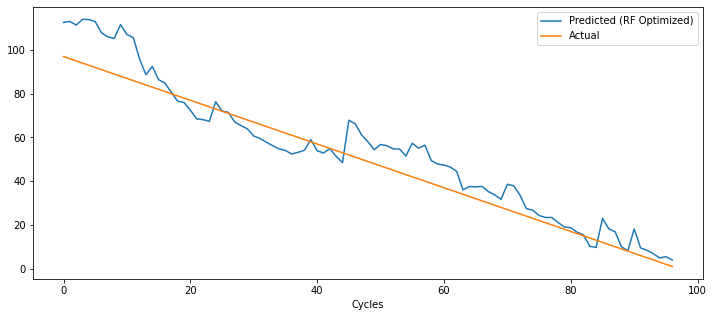

In [32]:
# Visualize predicted RUL vs Actual RUL
ypred = pd.Series(y_pred_tuned_rf)
ytest = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred, label = "Predicted (RF Optimized)")
ax.plot(ytest, label = "Actual")
ax.set_xlabel("Cycles")


plt.legend()
plt.show()

### XGBoost

In [37]:
# train XGBoost with the best hyperparameters found by Optuna
xgb_model_tuned = xgb.XGBRegressor(objective='reg:squarederror', **best_params_xgb)
xgb_model_tuned.fit(X_train, y_train)

# Make  predictions with the optimized models
y_pred_tuned_xgb = xgb_model_tuned.predict(X_test)

# Evaluate the final models
rmse_tuned_xgb = np.sqrt(mean_squared_error(y_test, y_pred_tuned_xgb))
mae_tuned_xgb = mean_absolute_error(y_test, y_pred_tuned_xgb)
mape_tuned_xgb = mean_absolute_percentage_error(y_test, y_pred_tuned_xgb)
print(f"Root Mean Squared Error: {rmse_tuned_xgb: .2f}")
print(f"Mean Absolute Error: {mae_tuned_xgb: .2f}")
print(f"Mean Absolute Percentage Error: {mape_tuned_xgb: .2%}")

Root Mean Squared Error:  14.28
Mean Absolute Error:  11.98
Mean Absolute Percentage Error:  40.81%


In [38]:
# add XGB final predictions to the dataframe
pdf['Predicted_Final_XGB'] = y_pred_tuned_xgb
pdf

,Cycle,Actual,Predicted_LR,Predicted_XGB,Predicted_RF,Predicted_tuned_RF,Predicted_Final_XGB
0,1,97,123.042614,115.557152,110.77,112.588149,117.940331
1,2,96,122.327072,116.591278,113.34,113.070460,123.510956
2,3,95,122.599748,115.506203,112.60,111.406883,119.567657
3,4,94,121.239895,119.670898,114.03,114.006417,125.878479
4,5,93,118.801202,121.542900,114.11,113.925865,124.834488
...,...,...,...,...,...,...,...
92,93,5,44.725196,6.173754,8.11,8.394960,7.459327
93,94,4,44.079510,5.136897,6.61,6.853000,5.937227
94,95,3,43.194201,1.794338,4.52,4.887327,4.282969
95,96,2,43.467084,3.916913,5.01,5.476395,4.437070


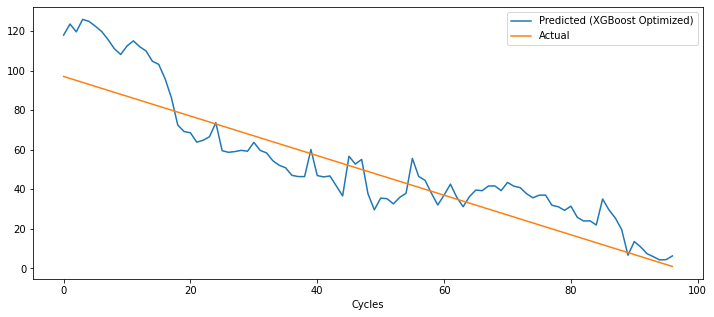

In [39]:
# Visualize predicted RUL vs Actual RUL
ypred = pd.Series(y_pred_tuned_xgb)
ytest = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred, label = "Predicted (XGBoost Optimized)")
ax.plot(ytest, label = "Actual")
ax.set_xlabel("Cycles")


plt.legend()
plt.show()

# Third Iteration

## Using normalized RUL

In [40]:
# normalize RUL values of train data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

In [41]:
# Transform the test set RUL values
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

### Baseline Model

In [42]:
# Define the Baseline model
model_norm_lr = LinearRegression()
# Train the model
model_norm_lr.fit(X_train, y_train_scaled.ravel())

# predict normalized RUL on test
y_pred_lrn = model_norm_lr.predict(X_test)

# Rescale predictions back to absolute RUL - for comparison purposes
y_pred_lr = scaler.inverse_transform(y_pred_lrn.reshape(-1, 1))

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)
mape = mean_absolute_percentage_error(y_test, y_pred_lr)
print(f"Root Mean Squared Error: {rmse: .2f}")
print(f"Mean Absolute Error: {mae: .2f}")
print(f"Mean Absolute Percentage Error: {mape: .2%}")

Root Mean Squared Error:  29.25
Mean Absolute Error:  28.64
Mean Absolute Percentage Error:  189.13%


In [43]:
# Dataframe (pdf) to compare actual vs predicted values
pdf['Predicted_LR_norm'] = y_pred_lr
pdf

,Cycle,Actual,Predicted_LR,Predicted_XGB,Predicted_RF,Predicted_tuned_RF,Predicted_Final_XGB,Predicted_LR_norm
0,1,97,123.042614,115.557152,110.77,112.588149,117.940331,123.042614
1,2,96,122.327072,116.591278,113.34,113.070460,123.510956,122.327072
2,3,95,122.599748,115.506203,112.60,111.406883,119.567657,122.599748
3,4,94,121.239895,119.670898,114.03,114.006417,125.878479,121.239895
4,5,93,118.801202,121.542900,114.11,113.925865,124.834488,118.801202
...,...,...,...,...,...,...,...,...
92,93,5,44.725196,6.173754,8.11,8.394960,7.459327,44.725196
93,94,4,44.079510,5.136897,6.61,6.853000,5.937227,44.079510
94,95,3,43.194201,1.794338,4.52,4.887327,4.282969,43.194201
95,96,2,43.467084,3.916913,5.01,5.476395,4.437070,43.467084


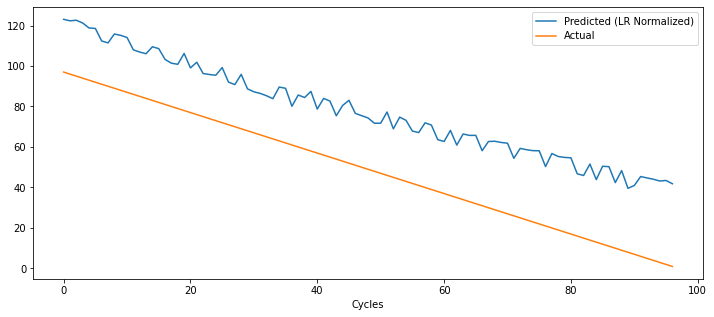

In [44]:
# Visualize predicted RUL vs Actual
# Visualize predicted RUL vs Actual
ypred_lr = pd.Series(y_pred_lr.ravel())  # Convert to 1-dimensional array
ytest_lr = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred_lr, label = "Predicted (LR Normalized)")
ax.plot(ytest_lr, label = "Actual")
ax.set_xlabel("Cycles")

plt.legend()
plt.show()


### RF

In [56]:
# Initialize and train the Random Forest model with 
model_norm_rf = RandomForestRegressor(n_estimators=100, 
                                     max_depth= None,
                                     max_features= "sqrt",
                                     min_samples_split= 2)
model_norm_rf.fit(X_train, y_train_scaled.ravel())

# predict normalized RUL on test
y_pred_rfn = model_norm_rf.predict(X_test)

# Rescale predictions back to absolute RUL - for comparison purposes
y_pred_rf = scaler.inverse_transform(y_pred_rfn.reshape(-1, 1))

# Evaluate the model
rmse_rfn = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rfn = mean_absolute_error(y_test, y_pred_rf)
mape_rfn = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"Root Mean Squared Error: {rmse_rfn: .2f}")
print(f"Mean Absolute Error: {mae_rfn: .2f}")
print(f"Mean Absolute Percentage Error: {mape_rfn: .2%}")

Root Mean Squared Error:  9.71
Mean Absolute Error:  7.84
Mean Absolute Percentage Error:  26.82%


In [46]:
# Dataframe (pdf) to compare actual vs predicted values
pdf['Predicted_RF_norm'] = y_pred_rf
pdf

,Cycle,Actual,Predicted_LR,Predicted_XGB,Predicted_RF,Predicted_tuned_RF,Predicted_Final_XGB,Predicted_LR_norm,Predicted_RF_norm
0,1,97,123.042614,115.557152,110.77,112.588149,117.940331,123.042614,115.06
1,2,96,122.327072,116.591278,113.34,113.070460,123.510956,122.327072,112.97
2,3,95,122.599748,115.506203,112.60,111.406883,119.567657,122.599748,111.61
3,4,94,121.239895,119.670898,114.03,114.006417,125.878479,121.239895,114.10
4,5,93,118.801202,121.542900,114.11,113.925865,124.834488,118.801202,114.12
...,...,...,...,...,...,...,...,...,...
92,93,5,44.725196,6.173754,8.11,8.394960,7.459327,44.725196,8.87
93,94,4,44.079510,5.136897,6.61,6.853000,5.937227,44.079510,7.86
94,95,3,43.194201,1.794338,4.52,4.887327,4.282969,43.194201,6.06
95,96,2,43.467084,3.916913,5.01,5.476395,4.437070,43.467084,6.54


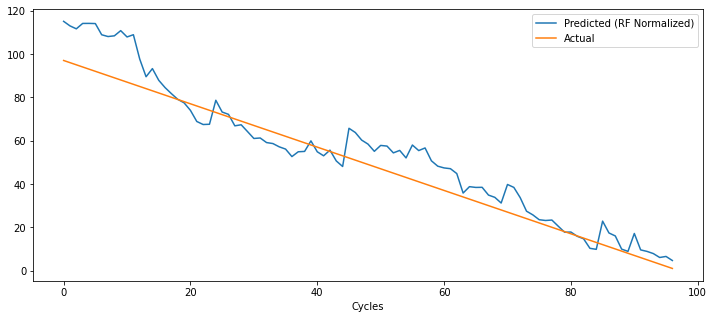

In [47]:
# Visualize predicted RUL vs Actual RUL
ypred = pd.Series(y_pred_rf.ravel())
ytest = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred, label = "Predicted (RF Normalized)")
ax.plot(ytest, label = "Actual")
ax.set_xlabel("Cycles")


plt.legend()
plt.show()

### XGBoost

In [49]:
# Initialize and train the XGBoost model
model_norm_xgb = xgb.XGBRegressor(objective ='reg:squarederror', 
                              n_estimators = 100, 
                              learning_rate = 0.3,
                              max_depth = 6, 
                              subsample = 1,
                              booster = 'gbtree')
model_norm_xgb.fit(X_train, y_train_scaled.ravel())

# predict normalized RUL on test
y_pred_xgbn = model_norm_xgb.predict(X_test)

# Rescale predictions back to absolute RUL - for comparison purposes
y_pred_xgb = scaler.inverse_transform(y_pred_xgbn.reshape(-1, 1))

# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"Root Mean Squared Error: {rmse_xgb: .2f}")
print(f"Mean Absolute Error: {mae_xgb: .2f}")
print(f"Mean Absolute Percentage Error: {mape_xgb: .2%}")

Root Mean Squared Error:  11.43
Mean Absolute Error:  8.98
Mean Absolute Percentage Error:  25.44%


In [57]:
# Dataframe (pdf) to compare actual vs predicted values
pdf['Predicted_XGB_norm'] = y_pred_xgb
pdf

,Cycle,Actual,Predicted_LR,Predicted_XGB,Predicted_RF,Predicted_tuned_RF,Predicted_Final_XGB,Predicted_LR_norm,Predicted_RF_norm,Predicted_XGB_norm
0,1,97,123.042614,115.557152,110.77,112.588149,117.940331,123.042614,115.06,124.759811
1,2,96,122.327072,116.591278,113.34,113.070460,123.510956,122.327072,112.97,123.060257
2,3,95,122.599748,115.506203,112.60,111.406883,119.567657,122.599748,111.61,121.663414
3,4,94,121.239895,119.670898,114.03,114.006417,125.878479,121.239895,114.10,119.482124
4,5,93,118.801202,121.542900,114.11,113.925865,124.834488,118.801202,114.12,119.078354
...,...,...,...,...,...,...,...,...,...,...
92,93,5,44.725196,6.173754,8.11,8.394960,7.459327,44.725196,8.87,6.946479
93,94,4,44.079510,5.136897,6.61,6.853000,5.937227,44.079510,7.86,7.387683
94,95,3,43.194201,1.794338,4.52,4.887327,4.282969,43.194201,6.06,1.829742
95,96,2,43.467084,3.916913,5.01,5.476395,4.437070,43.467084,6.54,3.810057


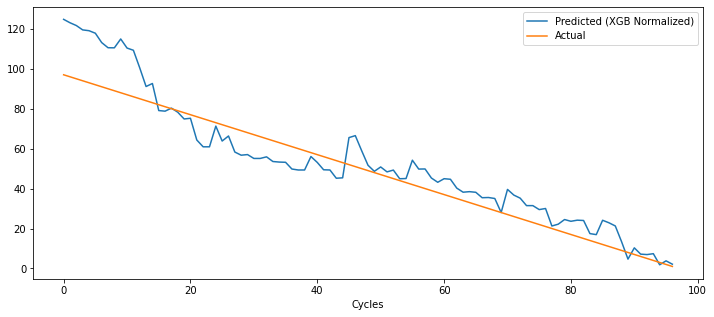

In [58]:
# Visualize predicted RUL vs Actual RUL
ypred = pd.Series(y_pred_xgb.ravel())
ytest = pd.Series(y_test)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.plot(ypred, label = "Predicted (XGB Normalized)")
ax.plot(ytest, label = "Actual")
ax.set_xlabel("Cycles")


plt.legend()
plt.show()